# Rule Based Log Data Analysis

This notebook will analyze the log data generated by the rule based policy in the building.

In [1]:
import pickle
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
data_loc = "../data/rule_based_log_data/<name_of_building>/log_data.csv"
df = pd.read_csv(data_loc)

## State Feature Plots

These plots are for visualizing the different state features in the dataset. This is also used to generate the frequencies for each value for each feature for the state transition model. The variable `bin_meta_<feature>` is used later to generate the state transition model.

By default this method uses the Feedman-Diaconis rule for estimating the bin width. You may choose other methods to calculate the bin size and width for your dataset accordingly.

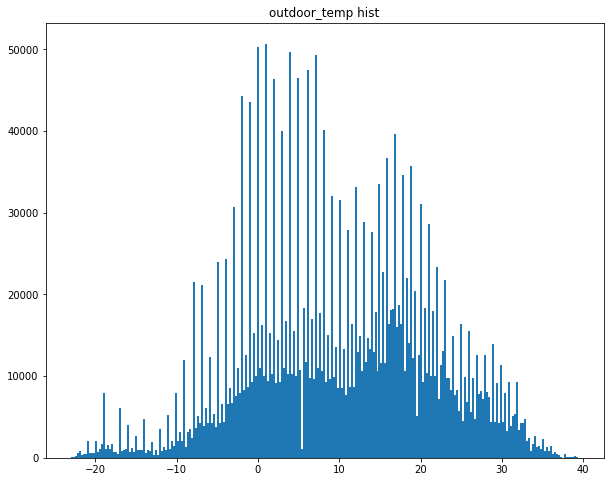

In [3]:
plt.figure(figsize=(10, 8))
plt.title("outdoor_temp hist")
bin_meta_outdoor_temp = plt.hist(df["outdoor_temp"], bins="fd")

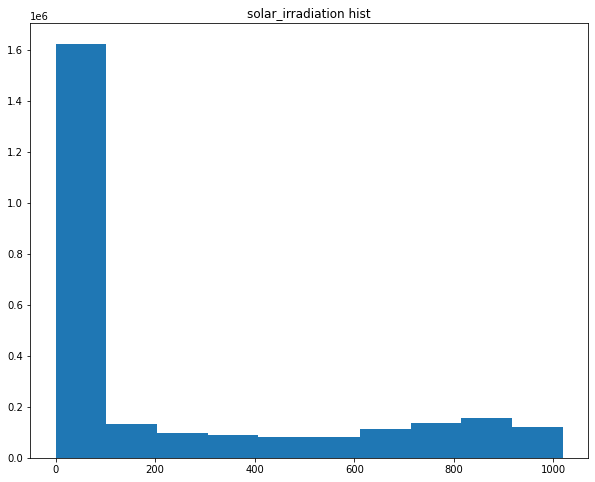

In [4]:
plt.figure(figsize=(10, 8))
plt.title("solar_irradiation hist")
bin_meta_solar = plt.hist(df["solar_irradiation"], bins="fd")

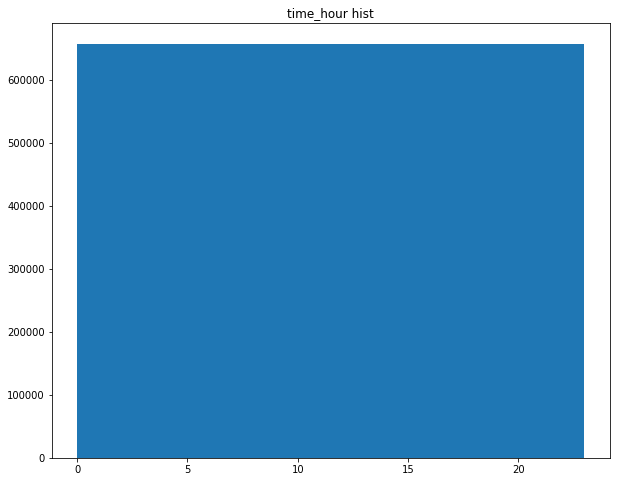

In [5]:
plt.figure(figsize=(10, 8))
plt.title("time_hour hist")
bin_meta_time = plt.hist(df["time_hour"], bins="fd")

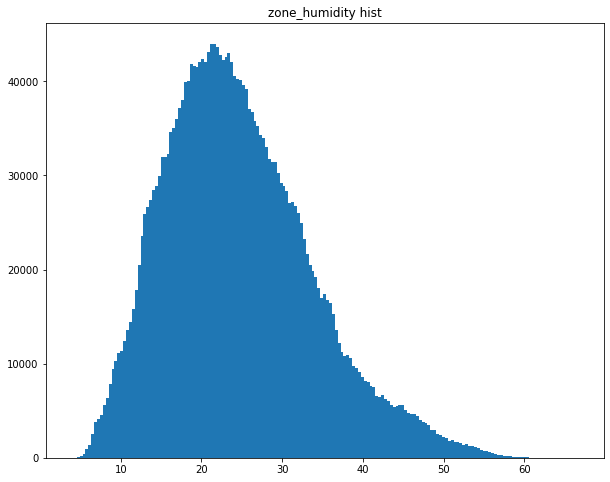

In [6]:
plt.figure(figsize=(10, 8))
plt.title("zone_humidity hist")
bin_meta_humid = plt.hist(df["zone_humidity"], bins="fd")

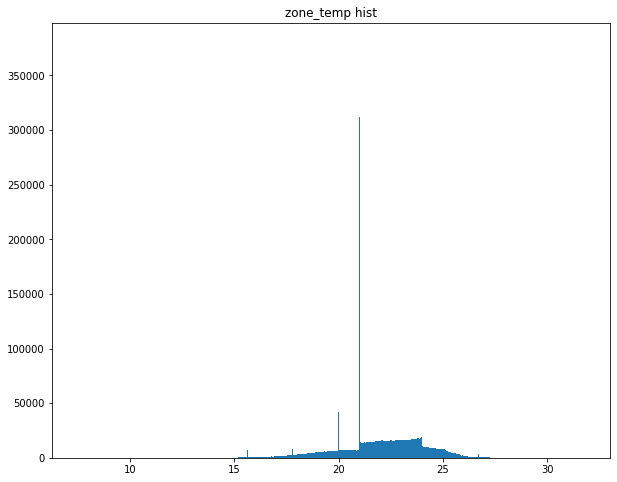

In [7]:
plt.figure(figsize=(10, 8))
plt.title("zone_temp hist")
bin_meta_temp = plt.hist(df["zone_temp"], bins='fd')

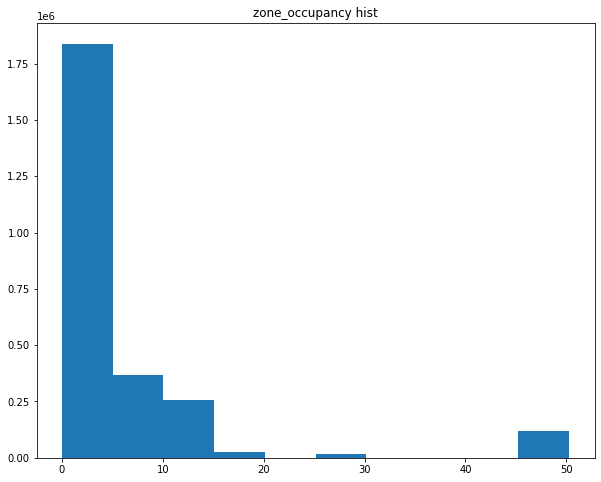

In [8]:
plt.figure(figsize=(10, 8))
plt.title("zone_occupancy hist")
bin_meta_occ = plt.hist(df["zone_occupancy"], bins='fd')

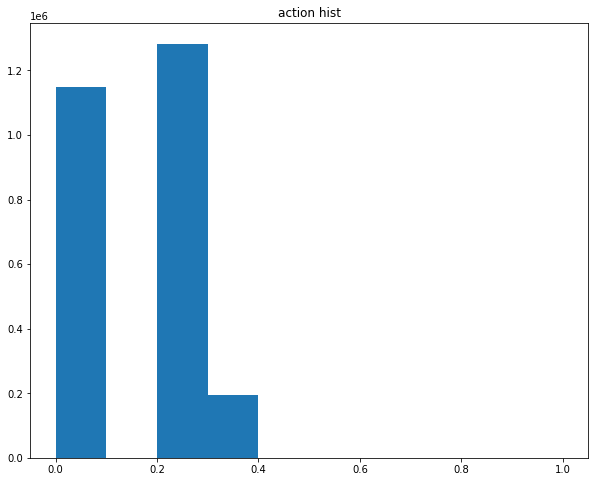

In [9]:
plt.figure(figsize=(10, 8))
plt.title("action hist")
bin_meta_action = plt.hist(df["action"], bins="fd")

## Generating the Action and State-Transition Probabilities

In [11]:
action_dims = len(df["action"].unique())

action_prob = {}
state_transition_prob = {}

df_dict = df.to_dict("records")  # Doing this is much faster than df.iterrows()

In [12]:
p_bar = tqdm(total=len(df))
for row in df_dict:
    outdoor_temp_bin = np.digitize(row["outdoor_temp"], bin_meta_outdoor_temp[1])-1
    solar_bin = np.digitize(row["solar_irradiation"], bin_meta_solar[1])-1
    time_bin = np.digitize(row["time_hour"], bin_meta_time[1])-1
    humidity_bin = np.digitize(row["zone_humidity"], bin_meta_humid[1])-1
    z_temp_bin = np.digitize(row["zone_temp"], bin_meta_temp[1])-1
    z_occ_bin = np.digitize(row["zone_occupancy"], bin_meta_occ[1])-1

    outdoor_temp_bin_tp1 = np.digitize(row["outdoor_temp_tp1"], bin_meta_outdoor_temp[1])-1
    solar_bin_tp1 = np.digitize(row["solar_irradiation_tp1"], bin_meta_solar[1])-1
    time_bin_tp1 = np.digitize(row["time_hour_tp1"], bin_meta_time[1])-1
    humidity_bin_tp1 = np.digitize(row["zone_humidity_tp1"], bin_meta_humid[1])-1
    z_temp_bin_tp1 = np.digitize(row["zone_temp_tp1"], bin_meta_temp[1])-1
    z_occ_bin_tp1 = np.digitize(row["zone_occupancy_tp1"], bin_meta_occ[1])-1
    
    s_t_str = f"{outdoor_temp_bin},{solar_bin},{time_bin},{humidity_bin},{z_temp_bin},{z_occ_bin}"
    s_tp1_str = f"{outdoor_temp_bin_tp1},{solar_bin_tp1},{time_bin_tp1},{humidity_bin_tp1},{z_temp_bin_tp1},{z_occ_bin_tp1}"
    
    if s_t_str not in state_transition_prob:
        state_transition_prob[s_t_str] = {}
    if s_tp1_str not in state_transition_prob[s_t_str]:
        state_transition_prob[s_t_str][s_tp1_str] = 0
        
    state_transition_prob[s_t_str][s_tp1_str] += 1
    
    action_bin = np.digitize(row["action"], bin_meta_action[1])-1
    
    
    if s_t_str not in action_prob:
        action_prob[s_t_str] = {}
    if action_bin not in action_prob[s_t_str]:
        action_prob[s_t_str][action_bin] = 0
    
    action_prob[s_t_str][action_bin] += 1
    p_bar.update(1)

action_prob["outdoor_temp_bins"] = bin_meta_outdoor_temp[1]
action_prob["solar_irradiation_bins"] = bin_meta_solar[1]
action_prob["time_hour_bins"] = bin_meta_time[1]
action_prob["zone_humidity_bins"] = bin_meta_humid[1]
action_prob["zone_temp_bins"] = bin_meta_temp[1]
action_prob["zone_occupancy_bins"] = bin_meta_occ[1]
action_prob["action_bins"] = bin_meta_action[1]
action_prob["total_count"] = len(df)
state_transition_prob["total_count"] = len(df)
p_bar.close()

  0%|          | 0/2627985 [00:00<?, ?it/s]

### Saving the Probabilities to a file

In [13]:
with open("../data/rule_based_log_data/<name_of_building>/action_probs_all_data.pkl", "wb+") as f:
    pickle.dump(action_prob, f)

with open("../data/rule_based_log_data/<name_of_building>/state_trans_prob_all_data.pkl", "wb+") as f:
    pickle.dump(state_transition_prob, f)